# 콜백을 사용하여 모델의 훈련 과정 제어하기
모델을 훈련할 때 미리 예상할 수 없는 것들이 많습니다. 특히 최적의 검증 손실을 얻기 위해 얼마나 많은 에포크가 필요한지 알지 못합니다. 지금까지 예에는 적절한 훈련 에포크를 알아내기 위해 첫번째 실행에서 과대적합이 시작될 때까지 충분한 에포크로 훈련했습니다. 그런 다음 최적의 에포크 횟수로 처음부터 새로운 훈련을 시작했습니다. 당연히 이런 방식은 낭비가 많습니다.

다음은 콜백을 사용하는 멫 가지 사례입니다.
* 모델 체크포인트 저장: 훈련하는 동안 어떤 지점에서 모델의 현재 가중치를 저장합니다.
* 조기 종료(early stopping): 검증 손실이 더 이상 향상되지 않을 때 훈련을 중지합니다(물론 훈련하는 동안 얻은 가장 좋은 모델을 저장합니다).
* 훈련하는 동안 하이퍼파라미터 값을 동적으로 조정합니다: 옵티마이저의 학습률 같은 경우입니다.
* 훈련과 검증 지표를 로그에 기록하거나 모델이 학습한 표현이 업데이트될 때마다 시각화합니다: 앞서 보았던 케라스의 진행 표시줄이 하나의 콜백입니다!

keras.callbacks 모듈은 많은 내장 콜백을 포함하고 있습니다(다음은 전체 리스트가 아닙니다).
* keras.callbacks.ModelCheckpoint
* keras.callbacks.EarlyStopping
* keras.callbacks.LearningRateScheduler
* keras.callbacks.ReduceLROnPlateau
* keras.callbacks.CSVLogger
콜백 사용법을 익히기 위해 ModelCheckpoint, EarlyStopping, ReduceLROnPlateau를 사용한 사용한 예를 상표봅시다.

# ModelCheckpoint와 EarlyStopping 콜백
EarlyStopping 콜백을 사용하면 정해진 에포크 동안 모니터링 지표가 향상되지 않을 때 훈련을 중지할 수 있습니다. 예를 들어 과대적합이 시작되자마자 훈련을 중지할 수 있습니다. 따라서 에포크 횟수를 줄여 다시 모델을 훈련할 필요가 없습니다. 일반적으로 이 콜백은 훈련하는 동안 모델을 계속 저장해 주는 ModelCheckpoint와 함께 사용합니다.(선택적으로 지금까지 가장 좋은 모델만 저장할 수 있습니다. 에포크 마지막에 다다랐을 때 최고 성능을 달성한 모델입니다.)

```python
import keras

# fit() 메서드의 callbacks 매개변수를 사용하여 콜백의 리스트를 모델로 전달합니다. 멫 개의 콜백이라도 전달할 수 있습니다.
callbacks_list = [keras.callbacks.EarlyStopping(     # 성능 향상이 멈추면 훈련을 중지합니다.
                    monitor'val_acc',                # 모델의 검증 정확도를 모니터링합니다.
                    patience=1),                     # 1 에포크보다 더 길게 (즉 2에포크 동안 정확도가 향상되지 않으면 훈련이 중지됩니다.)
                  keras.callbacks.ModelCheckpoint(   # 에포크마다 현재 가중치를 저장합니다.
                    filepath='my_model.h5',          # 모델 파일의 경로
                    monitor='val_loss',              # 이 두 매개변수는 val_loss가 좋아지지 않으면 모델 파일을 덮어쓰지 않는가는 뜻.
                    save_best_only=True)]            # 훈련하는 동안 가장 좋은 모델이 저장됩니다.

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])  # 정확도를 모니터링 하므로 모델 지표에 포함되어야 합니다.

# 콜백이 검증 손실과 검증 정확도를 모니터링 하기 때문에 validation_data 매개변수에 검증 데이터를 전달해야 합니다.
model.fit(x, y, epochs=10, batch_size=32, callbacks=callbacks_list, vakudation_data=(x_val, y_val))
```

# ReduceLROnPlateau 콜백
이 콜백을 사용하면 검증 손실이 향상되지 않을 때 학습률을 작게 할 수 있습니다. 손실 곡선이 평탄할 때 학습률을 작게 하거나 크게 하면 훈련 도중 지역 최솟값에서 효과적으로 빠져나올 수 있습니다. 다음은 ReduceLROnPlateau 콜백을 사용하는 예입니다.
```python
callbacks_list = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss',   # 모델의 검증 손실을 모니터링합니다.
                                   factor=0.1,        # 콜백이 호출될 때 학습률을 10배로 줄입니다.
                                   patience=10)]       # 컴증 손실이 10 에포크 동안 좋아지지 않으면 콜백이 호출됩니다.

# 콜백이 검증 손실과 검증 정확도를 모니터링 하기 때문에 validation_data 매개변수에 검증 데이터를 전달해야 합니다.
model.fit(x, y, epochs=10, batch_size=32, callbacks=callbacks_list, vakudation_data=(x_val, y_val))
```

# 자신만의 콜백 만들기
내장 콜백에서 제공하지 않는 특수한 행동이 훈련도중 필요하면 자신만의 콜백을 만들 수 있습니다. 콜백은 keras.callbacks.Callback클래스를 상속받아 구현합니다. 그다음 훈련하는 동안 호출될 여러 지점을 나타내기 위해 약속된 다음 메서드를 구현합니다.
* on_epoch_begin   # 각 에포크가 시작할 때 호출합니다.
* on_epoch_end    # 각 에포크가 끝날 때 호출합니다.
* on_batch_begin   # 각 배치 처리가 시작되기 전에 호출합니다.
* on_betch_begin   # 각 배치 처리가 끝난 후에 호출합니다.
* on_train_begin   # 훈련이 시작될 때 호출합니다.
* on_train_end    # 훈련이 끝날 때 호출합니다.
이 메서드들은 모두 logs 매개변수와 함께 호출됩니다. 이 매개변구에는 이전 배치, 에포크에 대한 훈련과 검증 측정값이 담겨 있는 딕셔너리가 전달됩니다. 또 콜백은 다음 속성을 참조할 수 있습니다.
* self.model: 콜백을 호출하는 모델 객체
* self.validation_data: fit() 메서드에 전달된 검증 데이터
다음은 매 에포크의 끝에서 검증 세트의 첫 번째 샘플로 모델에 있는 모든 층의 활성화 출력을 계산하여 (넘파이 배열로) 디스크에 저장하는 자작 콜백의 예입니다.

In [1]:
import tensorflow as tf   #tf 2.0 GPU error 해결법
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.7)

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [2]:
from tensorflow import keras
import numpy as np

class ActivationLogger(keras.callbacks.Callback):
    def set_model(self, model):              # 호출하는 모델에 대한 정보를 전달하기 위해 훈련하기 전에 호출됩니다.
        self.model = model
        layer_outputs = [layer.output for layer in model.layers]
        self.activations_model = keras.models.Model(model.input, layer_ouputs)  # 각 층의 활성화 출력을 반환하는 Model 객체입니다.
    
    def on_epochs_end(self, epoch, logs=None):
        if self.validation_data is None:
            raise RuntimeError('Requires validation_data.')
        
        validation_sample = self.validation_data[0][0:1]          # 검증 데이터의 첫번째 샘플을 가져옵니다.
        activations = self.activations_model.predict(validation_sample)
        f = open('activations_at_epoch_'+str(epoch)+'.npz', 'wb')
        np.savez(f, activations)
        f.close()

# 텐서보드 소개: 텐서플로의 시각화 프레임워크
이 절에서는 텐서플로와 함께 제공되는 브라우저 기반 시각화 도구인 텐서보드를 소개합니다. 덴서플로 백엔드로 케라스를 설정한 경우에만 케라스 모델에서 사용할 수 있습니다.

텐서보드의 핵심 목적은 훈련 모델의 내부에서 일어나는 모든 것을 시각적으로 모니터링할 수 있도록 돕는 것있습니다. 모델의 최종 손실 외에 더 많은 정보를 모니터링하면 모델 작동에 대한 명확한 그림을 그릴 수 있습니다. 결국 모델을 더 빠르게 개선할 수 있습니다. 텐서보드는 여러 가지 멋진 기능을 제공합니다. 모두 브라우저에서 작동합니다.
* 훈련하는 동안 측정 지표를 시각적으로 모니터링 합니다.
* 모델 구조를 시각화 합니다.
* 활성화 출력과 그래디언트의 히스토그램을 그립니다.
* 3D로 임베딩을 표현합니다.
간단한 예를 사용하여 이 기능들을 실습해 보죠. IMDB 감성 분석 문제를 위해 1D 컨브넷을 훈련하겠습니다. 이 모델은 6장 마지막 절에서 보았던 것과 비슷합니다. IMDB 어휘 사전에서 빈도가 높은 2000개 단어만 사용하겠습니다. 이렇게 하면 단어 임베딩을 시각화하기가 조금 더 쉽습니다.

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 50000
max_len = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

model = keras.models.Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len, name='embed'))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed (Embedding)            (None, 500, 128)          6400000   
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 6,435,937
Trainable params: 6,435,937
Non-trainable params: 0
______________________________________________

In [4]:
callbacks = [keras.callbacks.TensorBoard(log_dir='my_log_dir',   # 로그 파일이 기록될 위치입니다.
                                         histogram_freq=1       # 1 에포크마다 활성화 출력의 히스토그램을 출력합니다.
                                         )]     # 1 에포크마다 임베딩 데이터를 기록합니다.
history = model.fit(x_train, y_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=callbacks)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 4s 221us/sample - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 2/20
20000/20000 [==============================] - 2s 105us/sample - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 3/20
20000/20000 [==============================] - 2s 105us/sample - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 4/20
20000/20000 [==============================] - 2s 105us/sample - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 5/20
20000/20000 [==============================] - 2s 106us/sample - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 6/20
20000/20000 [==============================] - 2s 105us/sample - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 7/20
20000/20000 [==============================] - 2s 107us/sample - loss: 7.7364 - acc: 0.4985 - val_lo

cmd 창에서 tensorboard --logdir=my_log_dir 입력

브라우저에서 http://localhost:6006 주소에 접속

텐서플로 연산의 그래프 외에 케라스의 keras.utils.plot_model 유틸리티는 모델의 층 그래프를 깔끔하게 그려 주는 기능을 제공합니다. 이를 사용하려면 파이썬의 pydot과 pydot-ng, graphviz라이브러리가 필요합니다. 간단하게 살펴봅시다.

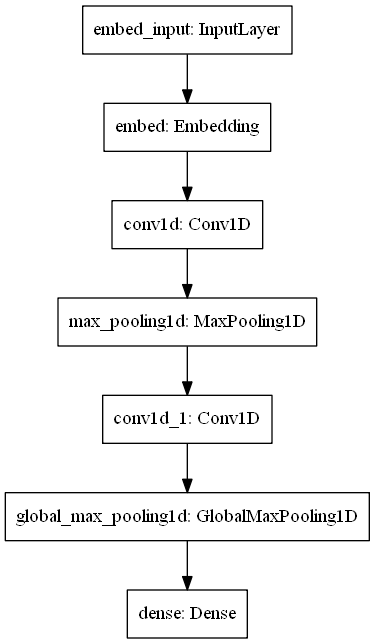

In [5]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

층 그래프에 ㅔ크기 정보를 추가할 수 있습니다. 다음은 plot_model함수와 show_shapes 매개변수를 사용하여 모ㅗ델의 그래프를 그립니다.

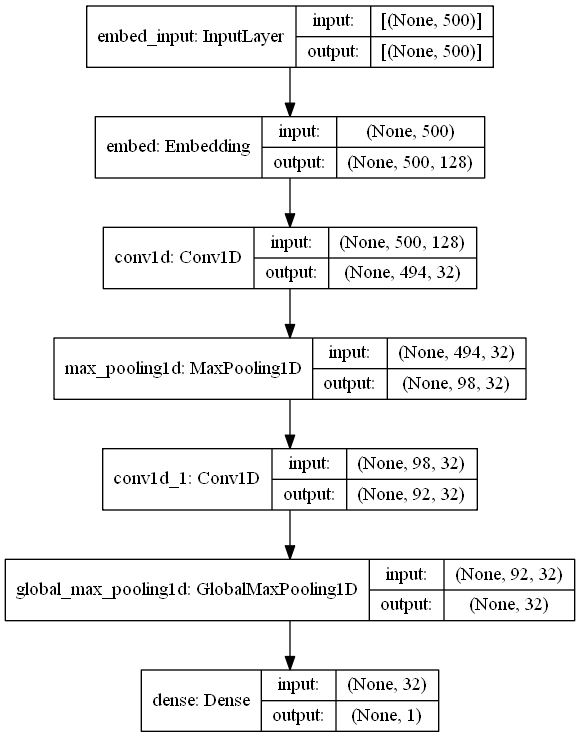

In [6]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='model.png') # show_layer_name=True, rankdir='TB','LR'